In [1]:
# import jax
import jax.numpy as jnp
import sacc
import emcee
import jax_cosmo as jc
import matplotlib.pylab as plt 
import numpy as np
import pyccl as ccl
import scipy.stats as ss 

# our scripts and functions 
# from sample import load_data
from cosmology.sampleemcee import emcee_logprior
from cosmology.bandpowers import get_bandpowers_theory, scale_cuts, get_nz, extract_bandwindow, extract_data_covariance
from cosmology.bandpowers import get_params_vec, get_gc_powerspectra, get_gc_wl_powerspectra, get_wl_powerspectra

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
ZMAX = 2.0
ELLMIN = 2
NELL = 30
ELLMAX_GC = 300
ELLMAX_WL = 3000
KMIN = 1E-4
KMAX = 50 
ZMIN = 0.0 
BAD_PS = 1E32


EPS = 1E-4
NSAMPLES  = 2

jc.power.USE_EMU = False

In [3]:
def load_data(fname="cls_DESY1", kmax=0.15, lmin_wl=30, lmax_wl=2000):
    saccfile = sacc.Sacc.load_fits(f"data/{fname}.fits")
    jax_nz_wl = get_nz(saccfile, tracertype="wl")
    jax_nz_gc = get_nz(saccfile, tracertype="gc")
    saccfile_cut = scale_cuts(saccfile, kmax=kmax, lmin_wl=lmin_wl, lmax_wl=lmax_wl)
    bw_gc, bw_gc_wl, bw_wl = extract_bandwindow(saccfile_cut)
    data, covariance = extract_data_covariance(saccfile_cut)
    newcov = covariance + jnp.eye(data.shape[0]) * 1e-18
    precision = jnp.linalg.inv(newcov)
    return data, precision, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl

In [4]:
def get_test_param():
    cosmo = jc.Cosmology(
        sigma8=0.852,
        Omega_c=0.239,
        Omega_b=0.054,
        h=0.653,
        n_s=0.933,
        w0=-1.0,
        Omega_k=0.0,
        wa=0.0,
    )

    parameter = get_params_vec(
        cosmo,
        [0.074, 0.186, -0.075, -0.108],  # multiplicative
        [-0.008, -0.100, -0.0018, -0.0097], # shifts wl 
        [0.359, -0.011], # [0.359, -0.011], # a_ia, eta
        [1.34, 1.58, 1.60, 1.90, 1.94],  # biases 
        [0.022, -0.0015, 0.02, 0.0097, -0.012] #, # shifts gc
    )
    return parameter



In [5]:
data, precision, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl = load_data(fname="cls_DESY1", kmax=0.15, lmin_wl=30, lmax_wl=2000)
parameters = get_test_param()

Maximum ell is 101
Maximum ell is 155
Maximum ell is 206
Maximum ell is 255
Maximum ell is 298


In [6]:
ps_gc, ells_coarse_gc, nbin_gc = get_gc_powerspectra(parameters, jax_nz_gc)
ps_wl, ells_coarse_wl, nbin_wl = get_wl_powerspectra(parameters, jax_nz_wl)
ps_gc_wl, ells_coarse_gc_wl, nbin_gc, nbin_wl = get_gc_wl_powerspectra(parameters, jax_nz_gc, jax_nz_wl)

Not using the emulator
Not using the emulator
Not using the emulator


# CCL

### Weak Lensing

In [7]:
def ccl_get_nz(fname="cls_DESY1", tracertype="wl"):
    sfile = sacc.Sacc.load_fits(f"data/{fname}.fits")
    tracers_names = list(sfile.tracers.keys())

    if tracertype == "wl":
        tname = "DESwl__"
    else:
        tname = "DESgc__"
    nbin = sum([tname in tracers_names[i] for i in range(len(tracers_names))])

    nz_distributions = list()
    for i in range(nbin):
        name = tname + str(i)
        distribution = sfile.tracers[name]
        jaxred = jc.redshift.custom_nz(
            distribution.z.astype("float64"),
            distribution.nz.astype("float64"),
            zmax=ZMAX,
        )
        nz_distributions.append(jaxred)

    return nz_distributions

def ccl_load_data(fname="cls_DESY1", kmax=0.15, lmin_wl=30, lmax_wl=2000):
    saccfile = sacc.Sacc.load_fits(f"data/{fname}.fits")
    saccfile_cut = scale_cuts(saccfile, kmax=kmax, lmin_wl=lmin_wl, lmax_wl=lmax_wl)
    bw_gc, bw_gc_wl, bw_wl = extract_bandwindow(saccfile_cut)
    
    data, covariance = extract_data_covariance(saccfile_cut)
    data = np.array(data)
    
    newcov = np.array(covariance) + np.eye(data.shape[0]) * 1e-18
    precision = np.linalg.inv(newcov)
    precision = np.array(precision)
    
    ccl_bw_gc = (
        np.array(bw_gc[0]),
        [np.array(bw_gc[1][i]) for i in range(len(bw_gc[1]))],
    )
    ccl_bw_gc_wl = (
        np.array(bw_gc_wl[0]),
        [np.array(bw_gc_wl[1][i]) for i in range(len(bw_gc_wl[1]))],
    )
    ccl_bw_wl = (
        np.array(bw_wl[0]),
        [np.array(bw_wl[1][i]) for i in range(len(bw_wl[1]))],
    )
    
    return data, precision, ccl_bw_gc, ccl_bw_gc_wl, ccl_bw_wl

def ccl_unpack_params_vec(params):
    cosmo = params[0:5]
    wl_multiplicative = params[5:9]
    wl_shifts = params[9:13]
    ia_params = params[13:15]
    gc_bias = params[15:20]
    gc_shifts = params[20:25]
    return cosmo, wl_multiplicative, wl_shifts, ia_params, gc_bias, gc_shifts

def numpy_interpolator(ellnew, ellcoarse, powerspectrum):
    ellnew_log = np.log(ellnew)
    ellcoarse_log = np.log(ellcoarse)
    powerspectrum_log = np.log(powerspectrum)
    ps_interp = np.interp(ellnew_log, ellcoarse_log, powerspectrum_log)
    return np.exp(ps_interp)


def ccl_get_bandpowers_gc(
    bandwindow_ells, bandwindow_matrix, ells_coarse, powerspectra, nbin_gc
):
    recordbandpowers = []
    counter = 0
    for i in range(nbin_gc):
        cls_wl_interp = numpy_interpolator(
            bandwindow_ells, ells_coarse, powerspectra[counter]
        )
        bandpowers = bandwindow_matrix[counter].T @ cls_wl_interp
        recordbandpowers.append(bandpowers)
        counter += 1
    return recordbandpowers


def ccl_get_bandpowers_gc_wl(
    bandwindow_ells, bandwindow_matrix, ells_coarse, powerspectra, nbin_gc, nbin_wl
):
    recordbandpowers = []
    counter = 0
    for i in range(nbin_gc):
        for j in range(nbin_wl):
            cls_wl_interp = numpy_interpolator(
                bandwindow_ells, ells_coarse, powerspectra[counter]
            )
            bandpowers = bandwindow_matrix[counter].T @ cls_wl_interp
            recordbandpowers.append(bandpowers)
            counter += 1
    return recordbandpowers


def ccl_get_bandpowers_wl(
    bandwindow_ells, bandwindow_matrix, ells_coarse, powerspectra, nbin_wl
):
    recordbandpowers = []
    counter = 0
    for i in range(nbin_wl):
        for j in range(i, nbin_wl):
            cls_wl_interp = numpy_interpolator(
                bandwindow_ells, ells_coarse, powerspectra[counter]
            )
            bandpowers = bandwindow_matrix[counter].T @ cls_wl_interp
            recordbandpowers.append(bandpowers)
            counter += 1
    return recordbandpowers

def ccl_get_test_param():
    cosmology = np.array([0.852, 0.239, 0.054, 0.653, 0.933])
    wl_multiplicative = np.array([0.074, 0.186, -0.075, -0.108])
    wl_shifts = np.array([-0.008, -0.100, -0.0018, -0.0097])
    ia_params = np.array([0.359, -0.011])
    gc_bias = np.array([1.34, 1.58, 1.60, 1.90, 1.94])
    gc_shifts = np.array([0.022, -0.0015, 0.02, 0.0097, -0.012])
    return np.concatenate([cosmology, wl_multiplicative, wl_shifts, ia_params, gc_bias, gc_shifts])

In [8]:
def intrinsic_alignment(redshift, amplitude, eta, redshift_fixed = 0.62):
    return amplitude * ((1 + redshift) / (1 + redshift_fixed)) ** eta

In [9]:
def run_simulator(cosmology):

    try:
        ccl_cosmo = ccl.Cosmology(sigma8=cosmology[0],
                                  Omega_c=cosmology[1], 
                                  Omega_b=cosmology[2], 
                                  h=cosmology[3], 
                                  n_s=cosmology[4], 
                                  transfer_function='boltzmann_camb')
    except:
        ccl_cosmo = None 

    return ccl_cosmo

In [10]:
class cosmoclass:

    def __init__(self, parameters, jax_nz_wl, jax_nz_gc):
        self.cosmo, self.multiplicative, self.deltaz_wl, self.ia_params, self.bias, self.deltaz_gc = ccl_unpack_params_vec(parameters)
        
        self.nz_wl_sys = [jc.redshift.systematic_shift(nzi, dzi) for nzi, dzi in zip(jax_nz_wl, self.deltaz_wl)]
        self.nz_gc_sys = [jc.redshift.systematic_shift(nzi, dzi, zmax=ZMAX) for nzi, dzi in zip(jax_nz_gc, self.deltaz_gc)]
        self.ells_coarse_wl = np.geomspace(ELLMIN, ELLMAX_WL, NELL, dtype=np.float32)
        self.ells_coarse_gc = np.geomspace(ELLMIN, ELLMAX_GC, NELL, dtype=np.float32)

        self.nbin_gc = len(self.deltaz_gc)
        self.nbin_wl = len(self.deltaz_wl)

        self.ccl_cosmo = run_simulator(self.cosmo)

def ccl_wl_powerspectra(nz_wl_sys, multiplicative, ia_params, ccl_cosmo, ells_coarse_wl):
    
    cl_wl_ccl = []
    nbin_wl = len(multiplicative)
    
    for i in range(nbin_wl):
        for j in range(i, nbin_wl):
    
            z_i = np.array(nz_wl_sys[i].params[0].params[0])
            z_j = np.array(nz_wl_sys[j].params[0].params[0])
    
            nz_i = np.array(nz_wl_sys[i].pz_fn(z_i))
            nz_j = np.array(nz_wl_sys[j].pz_fn(z_j))

            m_i = multiplicative[i]
            m_j = multiplicative[j]
            
            A_IA_i = intrinsic_alignment(z_i, ia_params[0], ia_params[1])
            A_IA_j = intrinsic_alignment(z_j, ia_params[0], ia_params[1])

            if ccl_cosmo is not None:
                t1 = ccl.WeakLensingTracer(ccl_cosmo, dndz=(z_i, nz_i), has_shear=True, ia_bias=(z_i, A_IA_i))
                t2 = ccl.WeakLensingTracer(ccl_cosmo, dndz=(z_j, nz_j), has_shear=True, ia_bias=(z_j, A_IA_j))
                cl = ccl.angular_cl(ccl_cosmo, t1, t2, ells_coarse_wl)  * (1.0 + m_i) * (1.0 + m_j)
            else:
                cl = np.ones_like(ells_coarse_wl) * BAD_PS
            
            cl_wl_ccl.append(cl)
    return cl_wl_ccl

def ccl_gc_powerspectra(nz_gc_sys, bias, ccl_cosmo, ells_coarse_gc):

    cl_gc_ccl = []
    nbin_gc = len(bias)
    for i in range(nbin_gc):
    
        redshift = np.array(nz_gc_sys[i].params[0].params[0])
        z_dist = np.array(nz_gc_sys[i].pz_fn(redshift))
        
        bias_i = bias[i] * np.ones_like(redshift)
        tracer = ccl.tracers.NumberCountsTracer(ccl_cosmo, dndz=(redshift, z_dist), bias = (redshift, bias_i), has_rsd=False)
        if ccl_cosmo is not None:
            cl = ccl.angular_cl(ccl_cosmo, tracer, tracer, ells_coarse_gc)
        else:
            cl = np.ones_like(ells_coarse_gc) * BAD_PS
        
        cl_gc_ccl.append(cl)
    return cl_gc_ccl

def ccl_gc_wl_powerspectra(nz_wl_sys, nz_gc_sys, multiplicative, ia_params, bias, ccl_cosmo, ells_coarse_gc):

    nbin_wl = len(multiplicative)
    nbin_gc = len(bias)
    
    cl_gc_wl_ccl = []
    for i in range(nbin_gc):
        for j in range(nbin_wl):
            # gc 
            z_i = np.array(nz_gc_sys[i].params[0].params[0])
            nz_i = np.array(nz_gc_sys[i].pz_fn(z_i))
            
            b_i = bias[i] * np.ones_like(z_i)
            
        
            # wl 
            z_j = np.array(nz_wl_sys[j].params[0].params[0])
            nz_j = np.array(nz_wl_sys[j].pz_fn(z_j))
            m_j = multiplicative[j]
            A_IA_j = intrinsic_alignment(z_j, ia_params[0], ia_params[1])
            
            if ccl_cosmo is not None:
                t_i = ccl.tracers.NumberCountsTracer(ccl_cosmo, dndz=(z_i, nz_i), bias = (z_i, b_i), has_rsd=False)
                t_j = ccl.WeakLensingTracer(ccl_cosmo, dndz=(z_j, nz_j), has_shear=True, ia_bias=(z_j, A_IA_j))
                cl = ccl.angular_cl(ccl_cosmo, t_i, t_j, ells_coarse_gc)  * (1.0 + m_j)
            else:
                cl = np.ones_like(ells_coarse_gc) * BAD_PS
                
            cl_gc_wl_ccl.append(cl)
    return cl_gc_wl_ccl

In [11]:
%%time
cosmolib = cosmoclass(np.array(parameters), jax_nz_wl, jax_nz_gc)

CPU times: user 732 µs, sys: 92 µs, total: 824 µs
Wall time: 865 µs


In [12]:
ccl_ps_wl = ccl_wl_powerspectra(cosmolib.nz_wl_sys, 
                                cosmolib.multiplicative, 
                                cosmolib.ia_params, 
                                cosmolib.ccl_cosmo, 
                                cosmolib.ells_coarse_wl)

ccl_ps_gc = ccl_gc_powerspectra(cosmolib.nz_gc_sys, 
                                cosmolib.bias, 
                                cosmolib.ccl_cosmo, 
                                cosmolib.ells_coarse_gc)

ccl_ps_gc_wl = ccl_gc_wl_powerspectra(cosmolib.nz_wl_sys, 
                                      cosmolib.nz_gc_sys, 
                                      cosmolib.multiplicative, 
                                      cosmolib.ia_params,
                                      cosmolib.bias, 
                                      cosmolib.ccl_cosmo, 
                                      cosmolib.ells_coarse_gc)

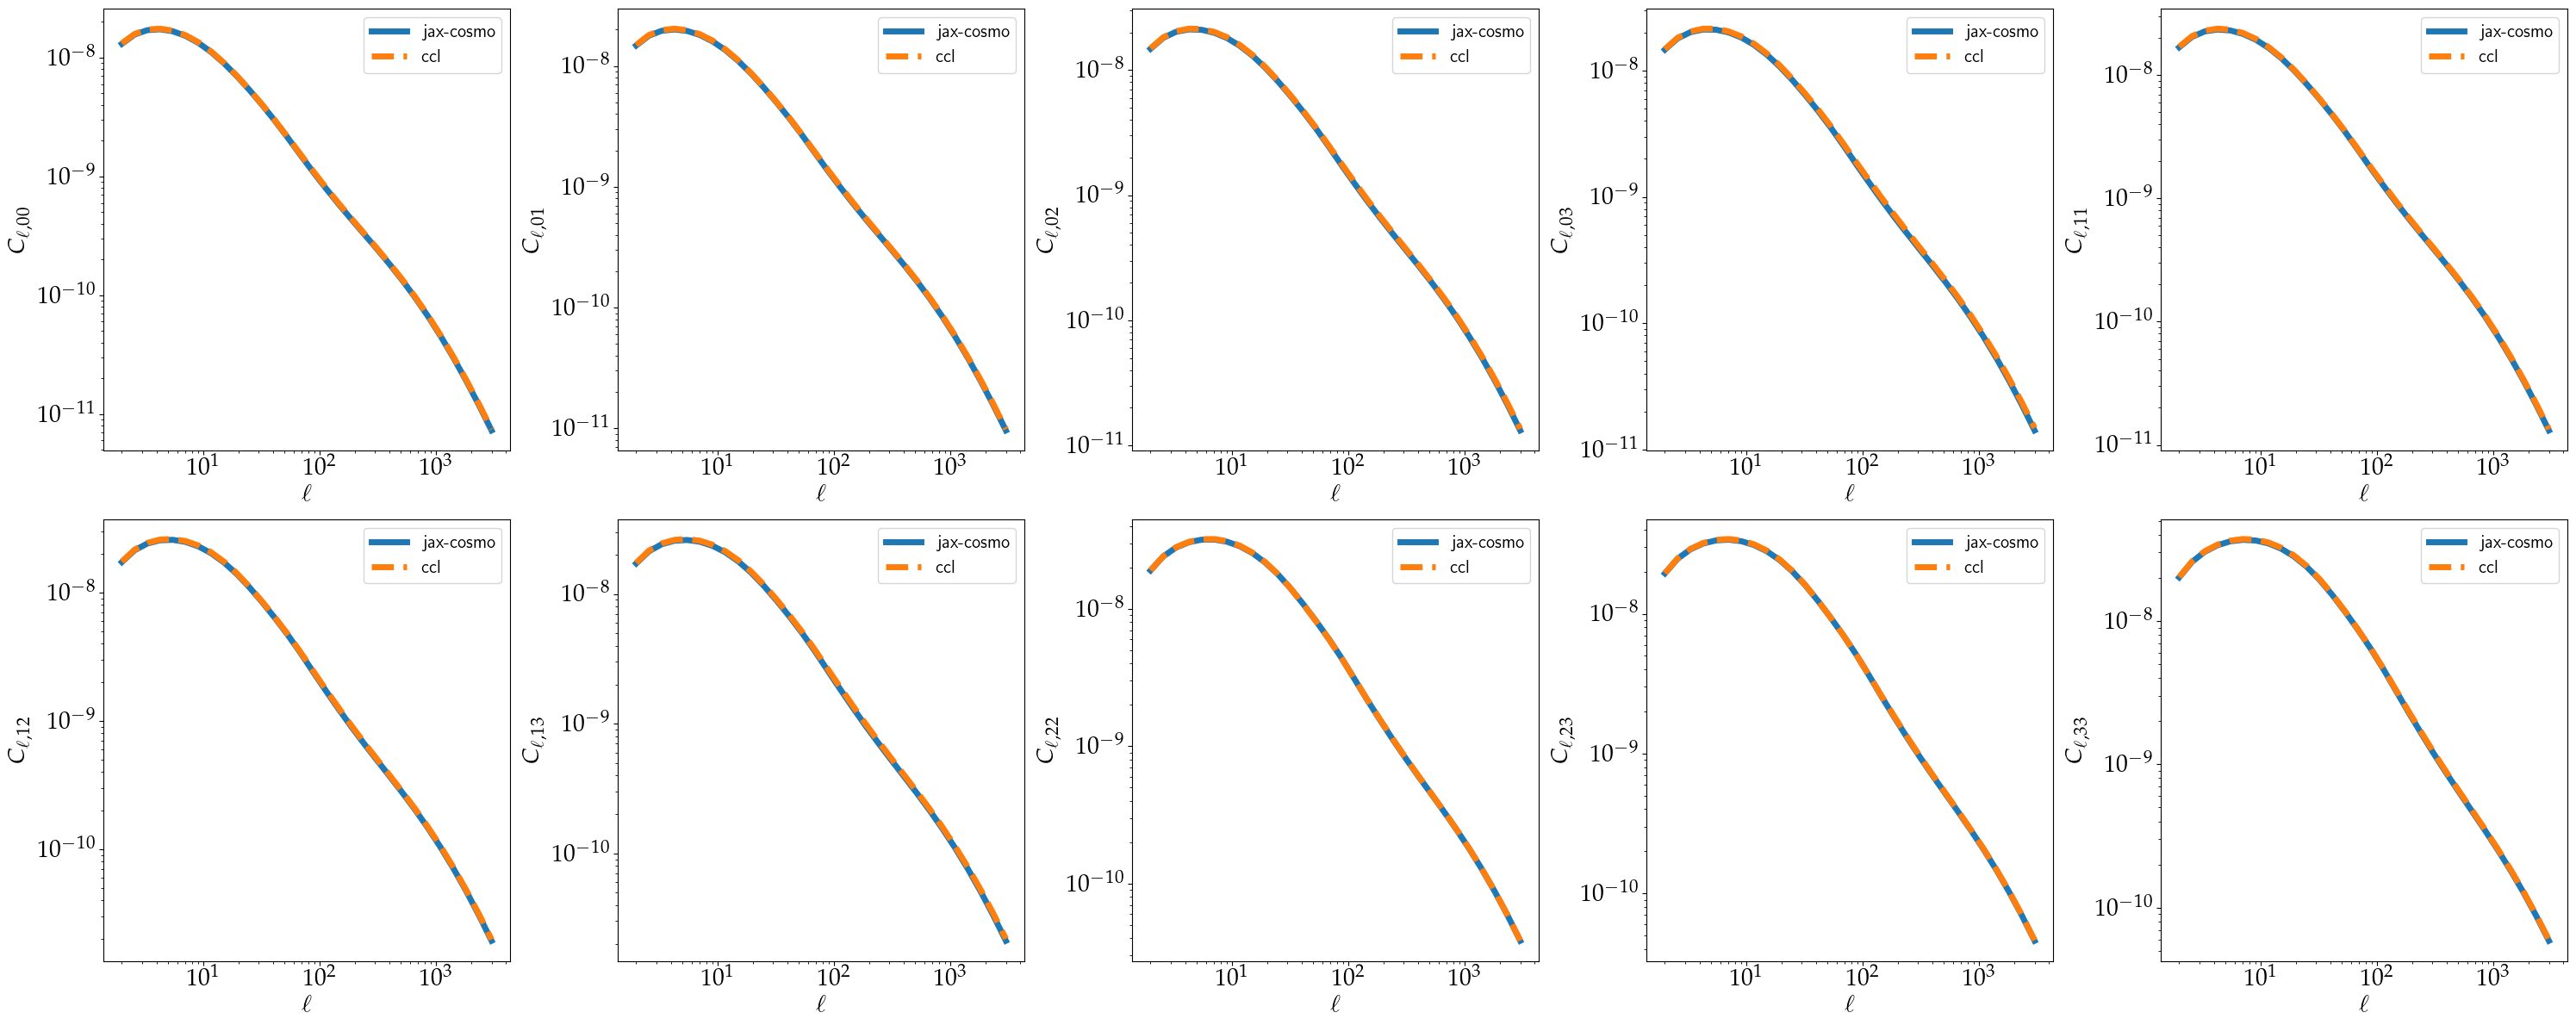

In [13]:
plt.figure(figsize = (30, 12))
counter = 0 
for i in range(4):
    for j in range(i, 4):
        plt.subplot(2, 5, counter+1)
        plt.loglog(ells_coarse_wl, ps_wl[counter], label = 'jax-cosmo', lw = 5)
        plt.loglog(ells_coarse_wl, ccl_ps_wl[counter], label = 'ccl', linestyle = '--', lw = 5)
        plt.ylabel('$C_{\ell,' + f'{i}{j}' + '}$', fontsize = fontSize)
        plt.xlabel(r'$\ell$', fontsize = fontSize)
        plt.tick_params(axis='x', labelsize=fontSize)
        plt.tick_params(axis='y', labelsize=fontSize)
        plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
        counter += 1
plt.tight_layout()
plt.show()

### Galaxy Clustering

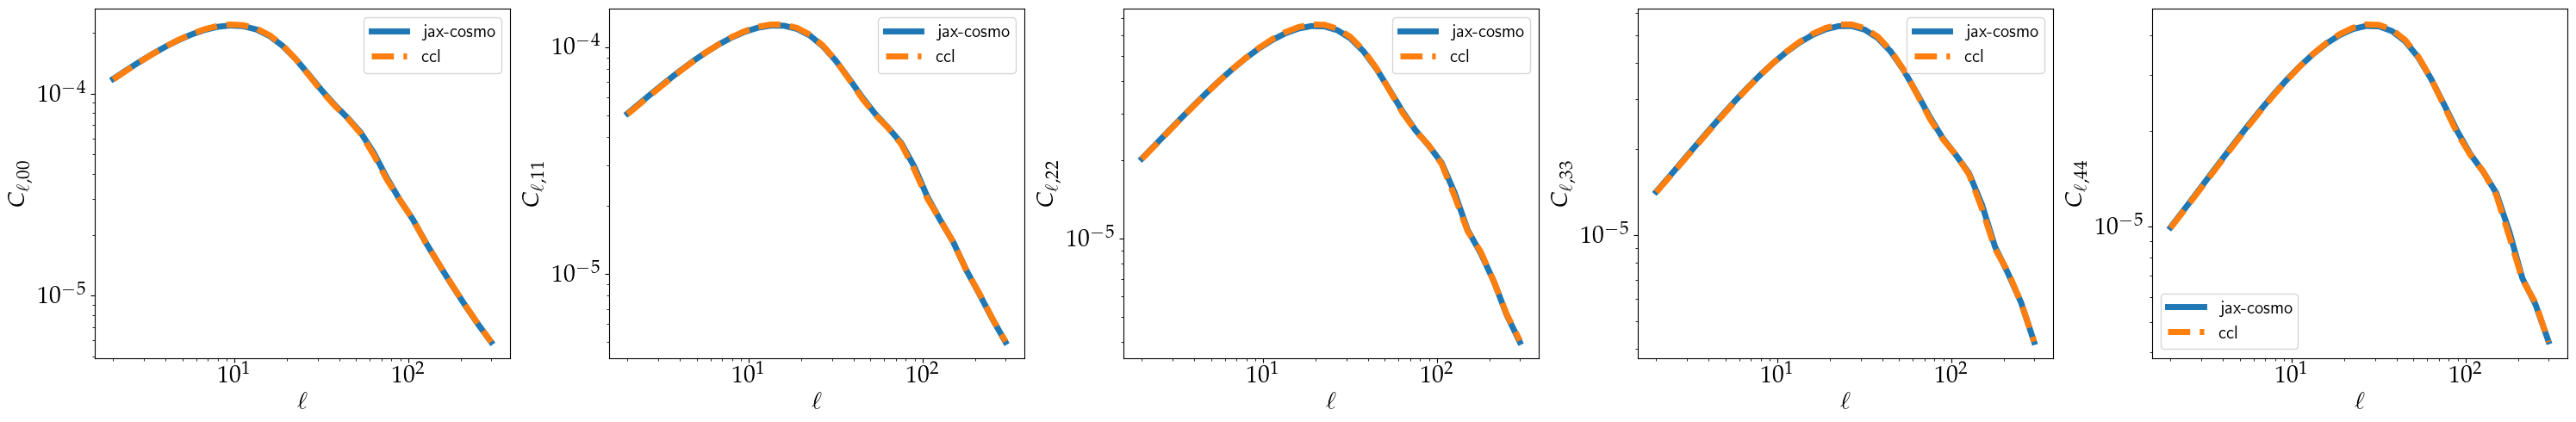

In [14]:
plt.figure(figsize = (30, 5))
for i in range(nbin_gc):
    plt.subplot(1, nbin_gc, i+1)
    plt.loglog(ells_coarse_gc, ps_gc[i], label = 'jax-cosmo', lw = 5)
    plt.loglog(ells_coarse_gc, ccl_ps_gc[i], label = 'ccl', linestyle = '--', lw = 5)
    plt.ylabel('$C_{\ell,' + f'{i}{i}' + '}$', fontsize = fontSize)
    plt.xlabel(r'$\ell$', fontsize = fontSize)
    plt.tick_params(axis='x', labelsize=fontSize)
    plt.tick_params(axis='y', labelsize=fontSize)
    plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.tight_layout()
plt.show()

### Weak Lensing and Galaxy Clustering

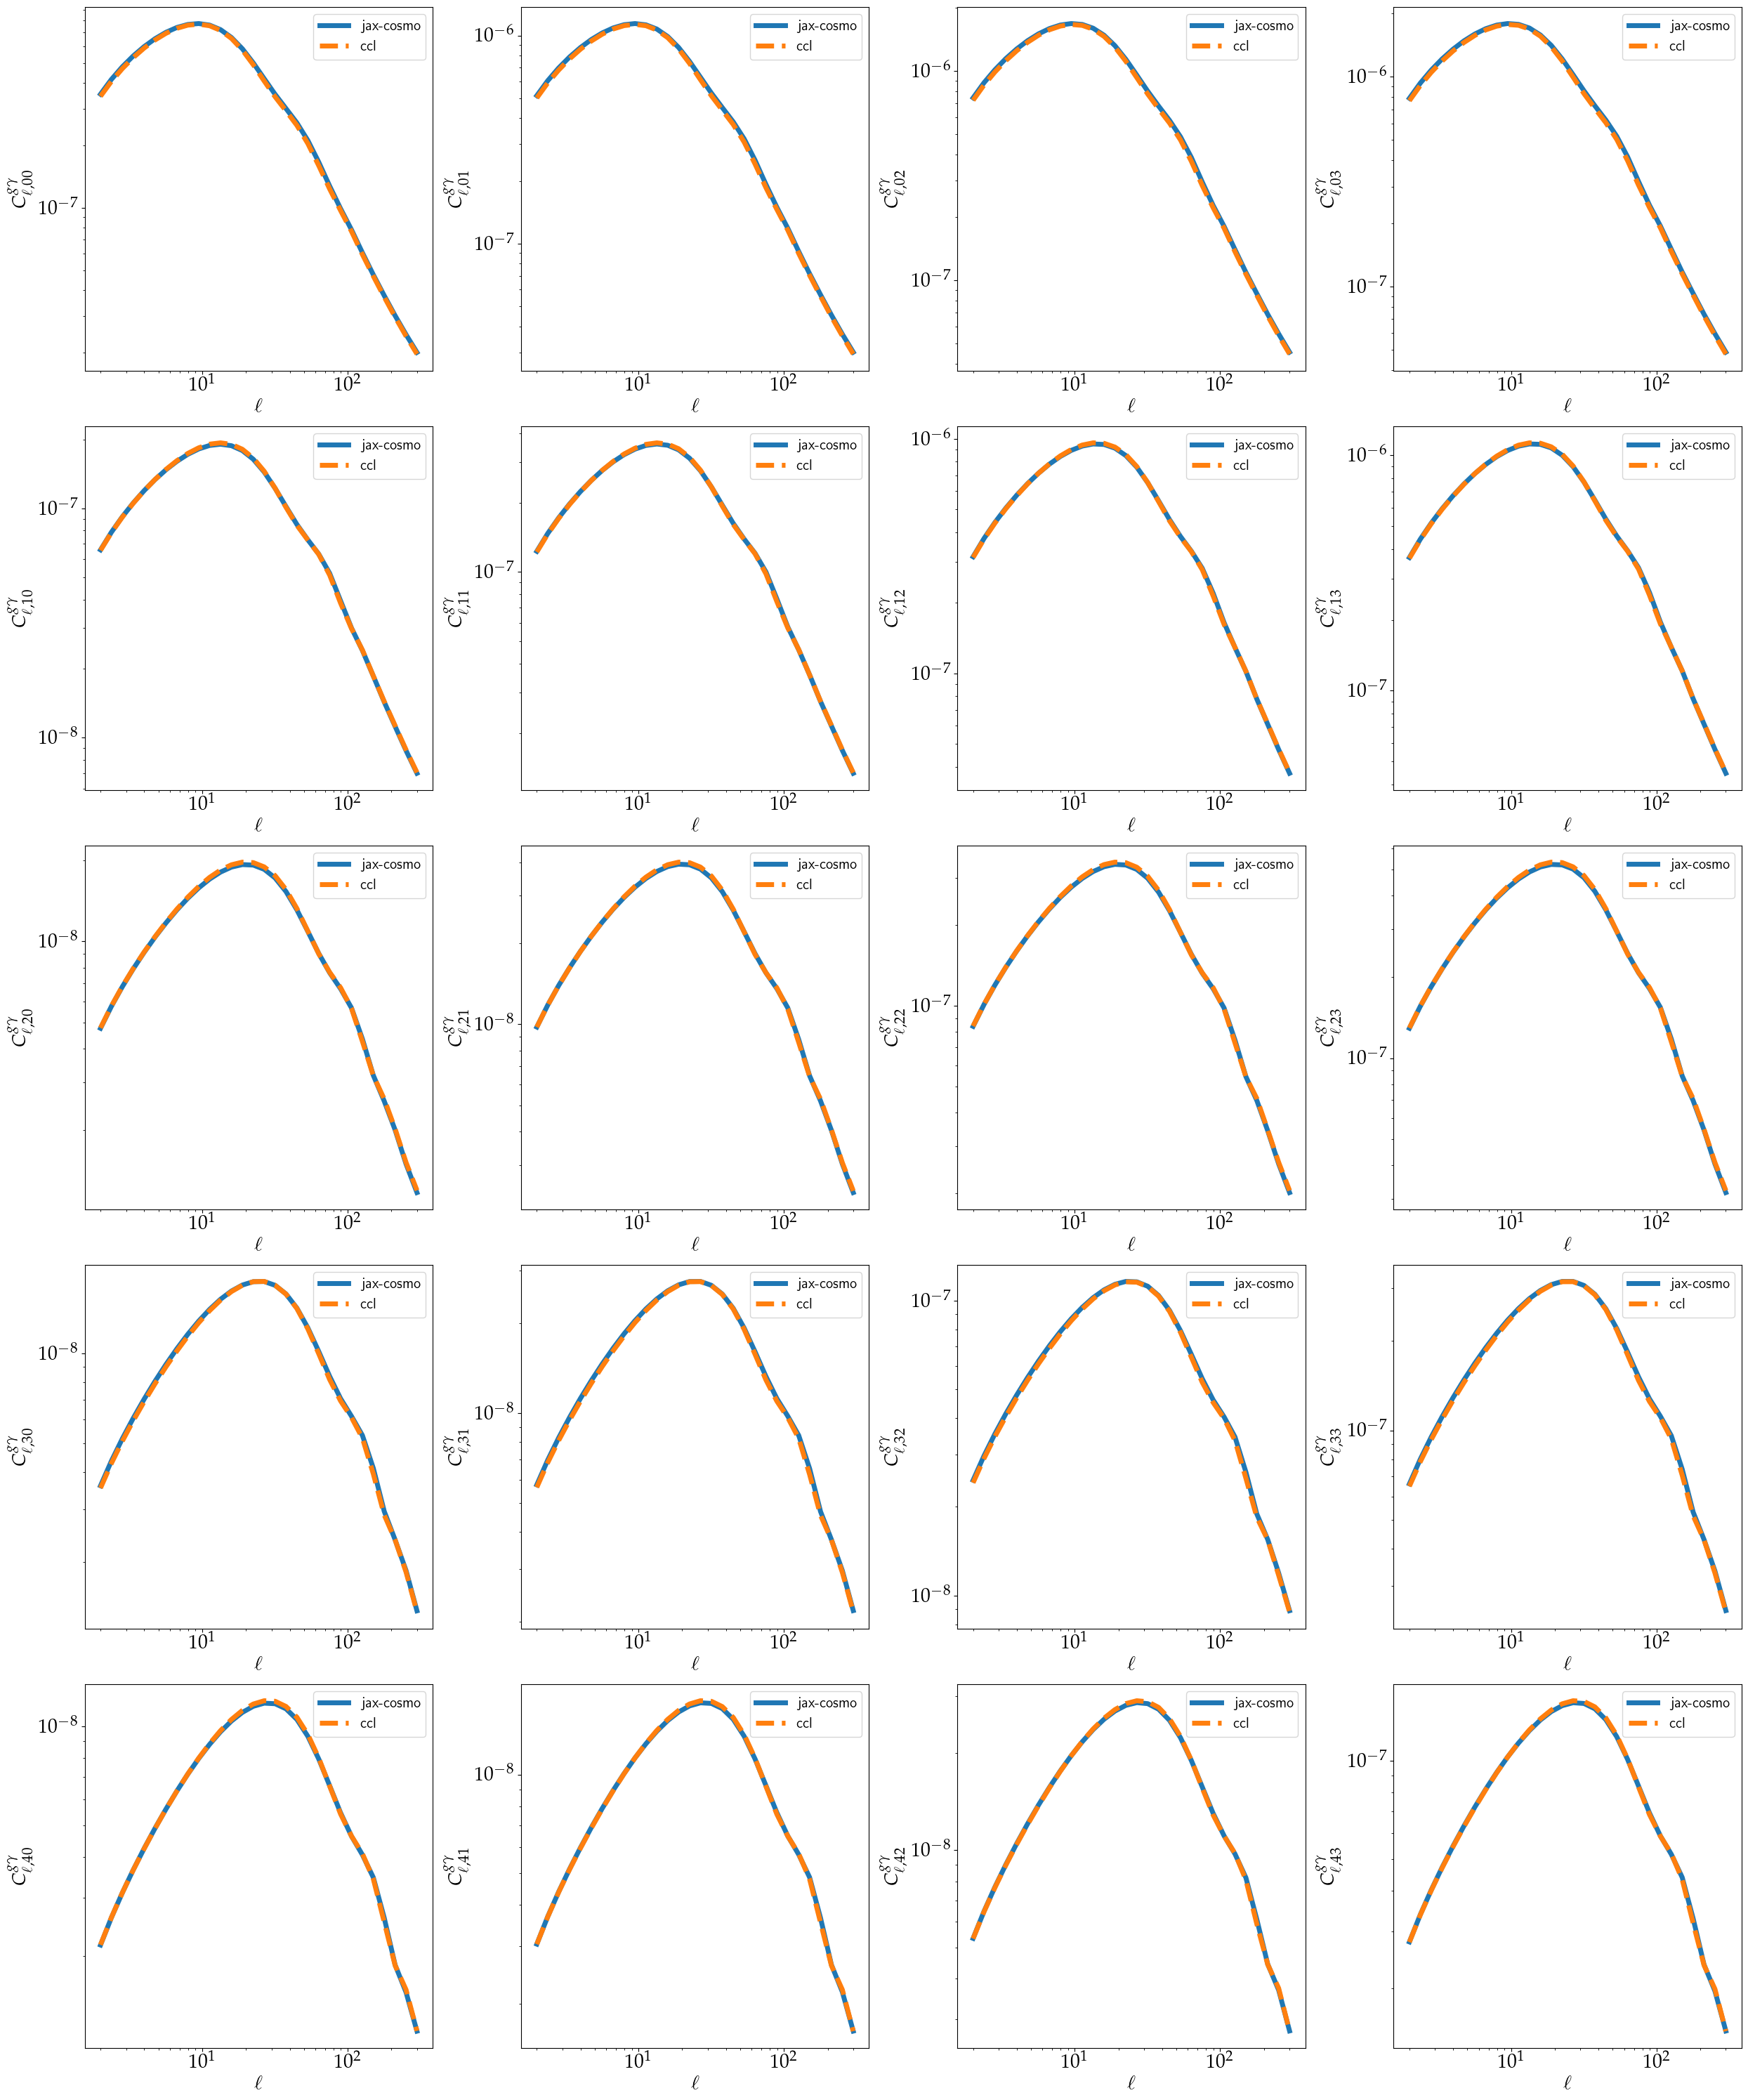

In [15]:
plt.figure(figsize = (25, 30))
counter = 0 
for i in range(nbin_gc):
    for j in range(nbin_wl):
        plt.subplot(nbin_gc, nbin_wl, counter+1)
        plt.loglog(ells_coarse_gc, ps_gc_wl[counter], label = 'jax-cosmo', lw = 5)
        plt.loglog(ells_coarse_gc, ccl_ps_gc_wl[counter], label = 'ccl', linestyle = '--', lw = 5)
        plt.ylabel('$C^{g\gamma}_{\ell,' + f'{i}{j}' + '}$', fontsize = fontSize)
        plt.xlabel(r'$\ell$', fontsize = fontSize)
        plt.tick_params(axis='x', labelsize=fontSize)
        plt.tick_params(axis='y', labelsize=fontSize)
        plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
        counter += 1
plt.tight_layout()
plt.show()

### Bandpowers Calculation

In [16]:
def ccl_gc_bandpower_calculation(cosmolib, bandwindow_ells, bandwindow_matrix):

    ccl_ps_gc = ccl_gc_powerspectra(cosmolib.nz_gc_sys, 
                                    cosmolib.bias, 
                                    cosmolib.ccl_cosmo, 
                                    cosmolib.ells_coarse_gc)

    gc_bandpowers = ccl_get_bandpowers_gc(bandwindow_ells, bandwindow_matrix, cosmolib.ells_coarse_gc, ccl_ps_gc, cosmolib.nbin_gc)
    return gc_bandpowers


def ccl_gc_wl_bandpower_calculation(cosmolib, bandwindow_ells, bandwindow_matrix):
    ccl_ps_gc_wl = ccl_gc_wl_powerspectra(cosmolib.nz_wl_sys, 
                                          cosmolib.nz_gc_sys, 
                                          cosmolib.multiplicative, 
                                          cosmolib.ia_params,
                                          cosmolib.bias, 
                                          cosmolib.ccl_cosmo, 
                                          cosmolib.ells_coarse_gc)

    gc_wl_bandpowers = ccl_get_bandpowers_gc_wl(bandwindow_ells, bandwindow_matrix, 
                                            cosmolib.ells_coarse_gc, ccl_ps_gc_wl, cosmolib.nbin_gc, cosmolib.nbin_wl)
    return gc_wl_bandpowers


def ccl_wl_bandpower_calculation(cosmolib, bandwindow_ells, bandwindow_matrix):
    ccl_ps_wl = ccl_wl_powerspectra(cosmolib.nz_wl_sys, 
                                    cosmolib.multiplicative, 
                                    cosmolib.ia_params,
                                    cosmolib.ccl_cosmo, 
                                    cosmolib.ells_coarse_wl)

    wl_bandpowers = ccl_get_bandpowers_wl(bandwindow_ells, bandwindow_matrix, cosmolib.ells_coarse_wl, ccl_ps_wl, cosmolib.nbin_wl)
    return wl_bandpowers

In [17]:
def ccl_get_bandpowers_theory(cosmolib, bw_gc, bw_gc_wl, bw_wl):

    theory_gc = ccl_gc_bandpower_calculation(cosmolib, bw_gc[0], bw_gc[1])
    theory_gc_wl = ccl_gc_wl_bandpower_calculation(cosmolib, bw_gc_wl[0], bw_gc_wl[1])
    theory_wl = ccl_wl_bandpower_calculation(cosmolib, bw_wl[0], bw_wl[1])

    concat_theory_gc = np.concatenate(theory_gc)
    concat_theory_gc_wl = np.concatenate(theory_gc_wl)
    concat_theory_wl = np.concatenate(theory_wl)
    return np.concatenate([concat_theory_gc, concat_theory_gc_wl, concat_theory_wl])

In [18]:
ccl_nz_wl = ccl_get_nz(fname="cls_DESY1", tracertype="wl")
ccl_nz_gc = ccl_get_nz(fname="cls_DESY1", tracertype="gc")
ccl_data, ccl_precision, ccl_bw_gc, ccl_bw_gc_wl, ccl_bw_wl = ccl_load_data(fname="cls_DESY1", kmax=0.15, lmin_wl=30, lmax_wl=2000)

Maximum ell is 101
Maximum ell is 155
Maximum ell is 206
Maximum ell is 255
Maximum ell is 298


In [19]:
%%time
ccl_theory = ccl_get_bandpowers_theory(cosmolib, ccl_bw_gc, ccl_bw_gc_wl, ccl_bw_wl)

CPU times: user 1.03 s, sys: 99.6 ms, total: 1.13 s
Wall time: 149 ms


In [20]:
jxc_theory = get_bandpowers_theory(parameters, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)

Not using the emulator
Not using the emulator
Not using the emulator


In [21]:
ccl_diff = ccl_data - ccl_theory 
jxc_diff = data - jxc_theory

In [22]:
ccl_diff @ ccl_precision @ ccl_diff

178.75254649862794

In [23]:
jxc_diff @ precision @ jxc_diff

Array(179.30037196, dtype=float64)

## Sampling

In [24]:
def ccl_emcee_logprior(parameters):
    # cosmological parameters
    logp_sigma8 = ss.uniform.logpdf(parameters[0], 0.60, 0.40)
    logp_omegac = ss.uniform.logpdf(parameters[1], 0.14, 0.21)
    logp_omegab = ss.uniform.logpdf(parameters[2], 0.03, 0.025)
    logp_hubble = ss.uniform.logpdf(parameters[3], 0.64, 0.18)
    logp_ns = ss.uniform.logpdf(parameters[4], 0.87, 0.20)

    # multiplicative factor (weak lensing)
    logp_m1 = ss.norm.logpdf(parameters[5], 0.012, 0.023)
    logp_m2 = ss.norm.logpdf(parameters[6], 0.012, 0.023)
    logp_m3 = ss.norm.logpdf(parameters[7], 0.012, 0.023)
    logp_m4 = ss.norm.logpdf(parameters[8], 0.012, 0.023)

    # shifts (weak lensing)
    logp_dz_wl_1 = ss.norm.logpdf(parameters[9], -0.001, 0.016)
    logp_dz_wl_2 = ss.norm.logpdf(parameters[10], -0.019, 0.013)
    logp_dz_wl_3 = ss.norm.logpdf(parameters[11], 0.009, 0.011)
    logp_dz_wl_4 = ss.norm.logpdf(parameters[12], -0.018, 0.022)

    # intrinsic alignment
    logp_a_ia = ss.uniform.logpdf(parameters[13], -1, 2)
    logp_eta = ss.uniform.logpdf(parameters[14], -5, 10)

    # multiplicative bias (galaxy clustering)
    logp_b1 = ss.uniform.logpdf(parameters[15], 0.8, 2.2)
    logp_b2 = ss.uniform.logpdf(parameters[16], 0.8, 2.2)
    logp_b3 = ss.uniform.logpdf(parameters[17], 0.8, 2.2)
    logp_b4 = ss.uniform.logpdf(parameters[18], 0.8, 2.2)
    logp_b5 = ss.uniform.logpdf(parameters[19], 0.8, 2.2)

    # shifts (galaxy clustering)
    logp_dz_gc_1 = ss.norm.logpdf(parameters[20], 0.0, 0.007)
    logp_dz_gc_2 = ss.norm.logpdf(parameters[21], 0.0, 0.007)
    logp_dz_gc_3 = ss.norm.logpdf(parameters[22], 0.0, 0.006)
    logp_dz_gc_4 = ss.norm.logpdf(parameters[23], 0.0, 0.01)
    logp_dz_gc_5 = ss.norm.logpdf(parameters[24], 0.0, 0.01)

    logp_cosmology = logp_sigma8 + logp_omegac + logp_omegab + logp_hubble + logp_ns
    logp_multiplicative = logp_m1 + logp_m2 + logp_m3 + logp_m4
    logp_shifts_wl = logp_dz_wl_1 + logp_dz_wl_2 + logp_dz_wl_3 + logp_dz_wl_4
    logp_intrinsic = logp_a_ia + logp_eta
    logp_bias = logp_b1 + logp_b2 + logp_b3 + logp_b4 + logp_b5
    logp_shifts_gc = (
        logp_dz_gc_1 + logp_dz_gc_2 + logp_dz_gc_3 + logp_dz_gc_4 + logp_dz_gc_5
    )
    logp = (
        logp_cosmology
        + logp_multiplicative
        + logp_shifts_wl
        + logp_intrinsic
        + logp_bias
        + logp_shifts_gc
    )
    if not np.isfinite(logp):
        logp = -1e32
    return logp


def ccl_likelihood(
    parameters, ccl_data, ccl_precision, ccl_nz_gc, ccl_nz_wl, ccl_bw_gc, ccl_bw_gc_wl, ccl_bw_wl
):
    logprior = ccl_emcee_logprior(parameters)
    if logprior == -1e32:
        chi_square = 1e32
    else:
        cosmolib = cosmoclass(parameters, ccl_nz_wl, ccl_nz_gc)
        ccl_theory = ccl_get_bandpowers_theory(cosmolib, ccl_bw_gc, ccl_bw_gc_wl, ccl_bw_wl)
        difference = ccl_data - ccl_theory
        chi_square = difference @ ccl_precision @ difference
        if not np.isfinite(chi_square):
            chi_square = 1e32
    return -0.5 * chi_square


def ccl_logpost(
    parameters, ccl_data, ccl_precision, ccl_nz_gc, ccl_nz_wl, ccl_bw_gc, ccl_bw_gc_wl, ccl_bw_wl
):
    loglike = ccl_likelihood(
        parameters, ccl_data, ccl_precision, ccl_nz_gc, ccl_nz_wl, ccl_bw_gc, ccl_bw_gc_wl, ccl_bw_wl
    )
    logprior = ccl_emcee_logprior(parameters)
    return loglike + logprior

def ccl_sampling_emcee(ccl_data, ccl_precision, ccl_nz_gc, ccl_nz_wl, ccl_bw_gc, ccl_bw_gc_wl, ccl_bw_wl):
    
    parameter = ccl_get_test_param()
    nparams = len(parameter)
    pos = parameter + EPS * np.random.normal(0, 1, (2 * nparams, nparams)
    )
    nwalkers, ndim = pos.shape
    sampler = emcee.EnsembleSampler(
        nwalkers,
        ndim,
        ccl_logpost,
        args=(data, ccl_precision, ccl_nz_gc, ccl_nz_wl, ccl_bw_gc, ccl_bw_gc_wl, ccl_bw_wl),
    )
    sampler.run_mcmc(pos, NSAMPLES, progress=True)
    # save_sampler(sampler, cfg)
    return sampler

In [25]:
# test_sampler = ccl_sampling_emcee(ccl_data, ccl_precision, ccl_nz_gc, ccl_nz_wl, ccl_bw_gc, ccl_bw_gc_wl, ccl_bw_wl)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:56<00:00, 58.01s/it]


In [27]:
# test_sampler.flatchain